Plots adversary win rate at varying adversary visits for the weaker new adversaries in the robustness paper.

In [11]:
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
from tqdm.notebook import tqdm

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col-aaai"),
    ]
)

utils.import_plt_sty("defense-macros.sty")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [12]:
def get_adv_win_grouped_by_adv_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = "index == index or index != index",
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by adversary visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("adv_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi


def plot_adv_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot win rate against varying adversary visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
    """
    DEFAULT_ADV_VISITS = 600
    fig, ax = plt.subplots(1, 1)

    for i, (df, label) in enumerate(dfs):
        m, l, h = get_adv_win_grouped_by_adv_visits(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)
        ax.plot(
            DEFAULT_ADV_VISITS,
            m.loc[DEFAULT_ADV_VISITS].item(),
            "D",
            color=COLORS[i],
            alpha=0.7,
        )

    ax.set_xscale("log")
    plt.ylim(-5, 105)
    plt.ylabel("Adversary win \\%")
    plt.xlabel("Adversary visits")
    plt.legend()

    return fig, ax

In [3]:
# match directory name, regex matching adversary name in the SGFs, label for the plot
advs = [
    (
        "ttseng-attack-b18-adv-visits-241126",
        "attack-b18",
        r"\koadvmedium{} vs. \dectwentythree{}",
    ),
    (
        "ttseng-atari-adv-visits-241126",
        "attack-h9",
        r"\attackhnine{} vs. \defenseiter{9}",
    ),
    (
        "ttseng-stall-adv-visits-241223",
        "attack-ft-h9",
        r"\stalladv{} vs. \defenseiter{9}",
    ),
]
dfs = []
for adv_dir, adv_name_regex, label in tqdm(advs):
    df = utils.parse_sgfs([f"/shared/match/{adv_dir}"])
    utils.parse_for_match(df, adv_name_regex=adv_name_regex)
    dfs.append((df, label))

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
orig_figsize = plt.rcParams["figure.figsize"]
with plt.style.context(
    {
        # This goes in the appendix so we can make it a little taller
        # "figure.figsize": (orig_figsize[0], orig_figsize[1] * 1.3),
        "legend.fontsize": 8,
    }
):
    fig, ax = plot_adv_visit_sweep(dfs)
fig.savefig("vs-adv-visits.pgf", backend="pgf", bbox_inches="tight")

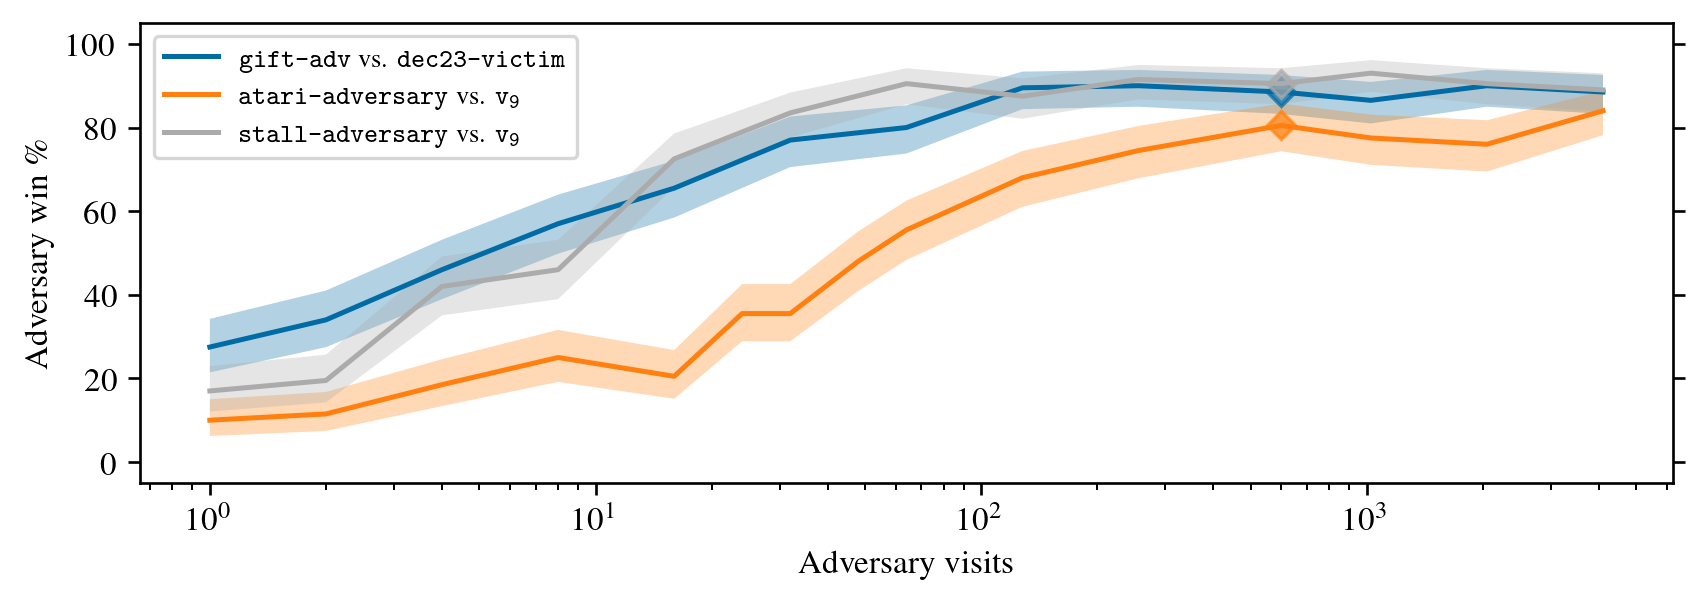

In [17]:
fig